In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
import statsmodels.regression.linear_model as lm
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
reg_df = pd.read_csv('Regression_data.csv', header = None, names = ['A','B','C'])

In [3]:
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
A    300 non-null float64
B    300 non-null float64
C    300 non-null float64
dtypes: float64(3)
memory usage: 7.1 KB


In [4]:
reg_df.head()

,A,B,C
0,0.490,-0.18,11.50
1,-1.410,-1.23,11.80
2,0.943,4.51,-3.24
3,3.570,5.07,-23.90
4,-1.700,6.91,-22.10


### Let's see how the data is distributed

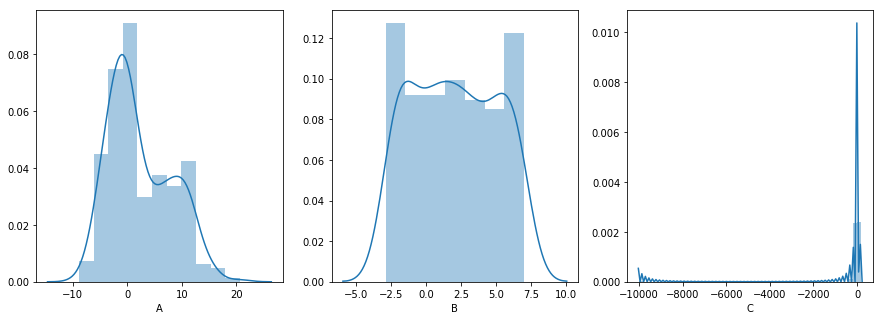

In [6]:
f,ax = plt.subplots(1,3, figsize = (15,5))
for col,axis in zip(reg_df.columns,ax.flatten()):
    sns.distplot(reg_df[col],ax = axis)

### Looks like C has some outliers

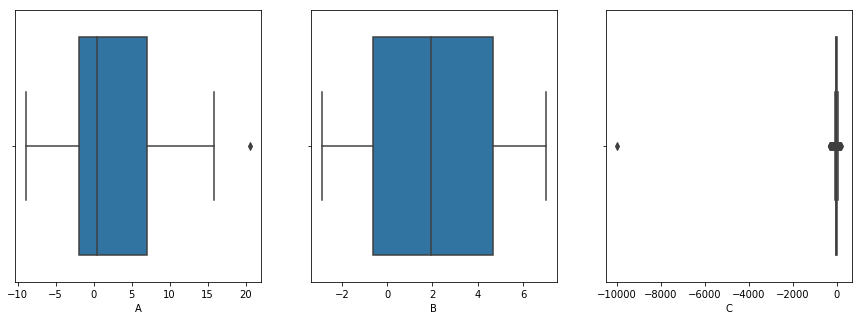

In [8]:
f,ax = plt.subplots(1,3, figsize = (15,5))
for col,axis in zip(reg_df.columns,ax.flatten()):
    sns.boxplot(reg_df[col],ax = axis)

As expected, C has outlier which has to be removed. A also has an outlier but our data is very small and this outlier may vanish if I increase threshold

### I'll see how this outlier of C looks in regression plot

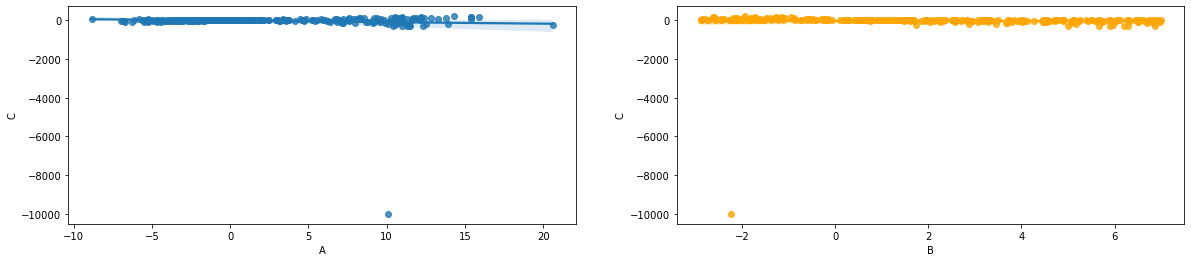

In [11]:
f,ax = plt.subplots(1,2,figsize = (20,4))
sns.regplot(x='A',y="C",data = reg_df, ax = ax[0])
sns.regplot(x='B',y="C",data = reg_df, ax = ax[1], color = 'orange')

### Removing Outlier from C

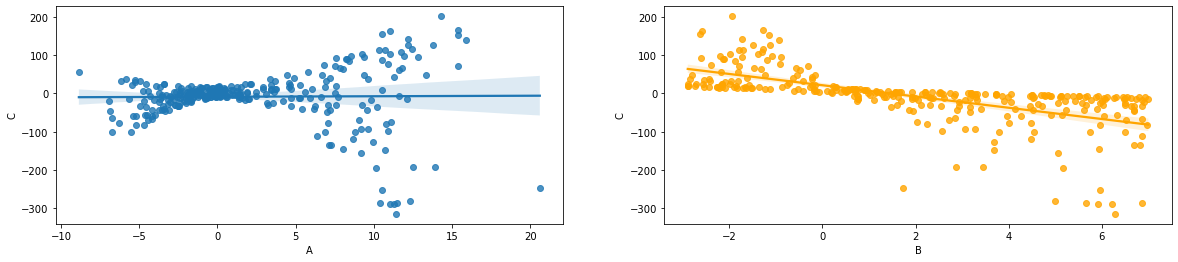

In [14]:
data = reg_df[reg_df.C != reg_df.C.min()]
f,ax = plt.subplots(1,2,figsize = (20,4))
sns.regplot(x='A',y="C",data = data, ax = ax[0])
sns.regplot(x='B',y="C",data = data, ax = ax[1], color = 'orange')

### Initially, I'll fit a linear regression model

Now, I will check how well A & B are correlated with C to understand the data

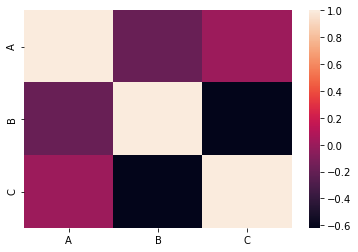

In [18]:
cor = data.corr()
sns.heatmap(cor)

A is very lightly correlated with C as compared to B but I'll not remove it for now. I'll see how the regression results looks

# Regression

I'll build a regression model with A,B as predictor variables and C as dependent variable. Since data is very small, building regresssion by estimating coefficients with normal equation is the optimal way to do it

<img src = 'pic.png' style = 'width:150px;height:120px' ?>

### Finding Coefficients and predicting outcomes

In [124]:
def predict(X,Y,data):
    """
    Parameters :
    X : Independent Variables Matrice as shown above
    Y : Dependent variable array
    data : to predict
    
    Returns:
    Y_hat : Predicted values of Y
    """
    X_trans = X.T
    X_dot = np.dot(X_trans,X)
    X_inv = np.linalg.inv(X_dot)
    XY = np.dot(X_trans,Y)
    A = np.dot(X_inv,XY) # A has coefficient estimates computed using formula above
    Y_hat = A[0] + A[1]*data.A + A[2]*data.B # predicting estimated Y using coefficients obtained in above step
    return Y_hat

#### Compute Root Mean Squared Error

In [125]:
def compute_RMSE(Y,Y_hat,data):
    """
    Parameters :
    Y : Dependent variable array
    Y_hat : Array with Predicted Values of Y
    data : to get shape of the data
    
    Returns:
    RMSE : Root Mean Squared Error
    """
    E = Y-Y_hat
    Error = np.dot((E.T),E)
    MSE = Error/data.shape[0]
    RMSE = math.sqrt(MSE)
    return RMSE

#### Compute RSquared

In [22]:
def compute_RSquared(Y,Y_hat,p=2):
    """
    Parameters :
    Y : Dependent variable array
    Y_hat : Array with Predicted Values of Y
    
    Returns:
    R-Squared
    Adjusted R_Squared
    """
    mean = np.mean(Y)
    sst = sum((Y - mean) ** 2)
    ssr = sum((Y - Y_hat) ** 2)
    r_squared = 1 - (ssr / sst)
    adj_rs = 1 - ((1-r_squared)*(Y.shape[0]-1))/(Y.shape[0] - p - 1)
    return r_squared,adj_rs

### Running model:

In [54]:
def model(data):
    X = data[['A','B']].to_numpy() # creating X matrice
    X = np.insert(X,0,1,axis = 1) # Adding 1 to get beta-zero while performing matrix multiplication
    Y = data.C # creating Y
    Y_hat = predict(X,Y,data) # Get predicted values
    RMSE = compute_RMSE(Y,Y_hat,data) # compute RMSE
    print("RMSE is :",RMSE)
    R_squared = compute_RSquared(Y,Y_hat) # compute Rsquared
    print("R-Squared is :",R_squared)
    return Y_hat,Y-Y_hat

RMSE is : 55.42728751329778
R-Squared is : (0.39402221021432304, 0.3899277656887441)


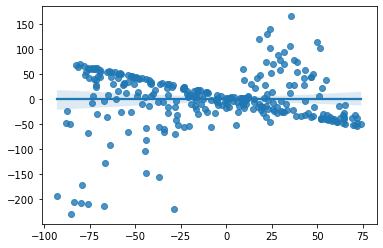

In [26]:
Y_hat,E = model(data)
sns.regplot(x=Y_hat,y=E)

###### Residual plot shows there might be a problem of heteroskedasticity and Non-linearity. Regplots of A Vs C and B Vs C shows cone shaped graph which indicates heteroskedasticity. I will perform log transformation on the data and see if data gets better

In [127]:
# Making sure all values are greater than zero before performing log transformation
log_data = data
for col in log_data.columns:
    if np.any(log_data[col] < 0):
        minimum = log_data[col].min()
        log_data[col] = log_data[col] + abs(minimum) + 0.01

In [128]:
# Applying Log transformation
log_data['A_log'] = np.log(log_data.A)
log_data['B_log'] = np.log(log_data.B)
log_data['C_log'] = np.log(log_data.C)
log_data = log_data[['A_log','B_log','C_log']]
log_data.columns = ['A','B','C']

In [129]:
np.any(np.isnan(log_data))

False

RMSE is : 0.6799448246854093
R-Squared is : (0.07019103042316999, 0.06390853738548874)


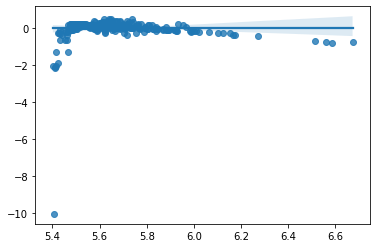

In [130]:
Y_hat,E = model(log_data)
sns.regplot(x=Y_hat,y=E)

In [131]:
log_data = log_data[log_data.C != log_data.C.min()]

RMSE is : 0.35230739137210754
R-Squared is : (0.14354919887927964, 0.1377427527699866)


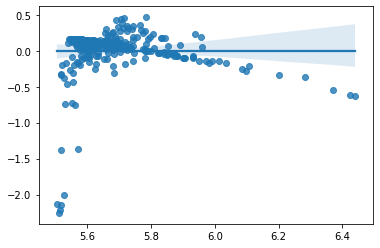

In [132]:
Y_hat,E = model(log_data)
sns.regplot(x=Y_hat,y=E)

#### From the residual plot, it looks like there is non linearity too and surely linear regression is not a good model. I'll transform data to remove non-linearity and try generalized least squares which removes heteroskedasticiy

#### Transforming data to remove non-linearity

In [116]:
sqrt_data = log_data
for col in sqrt_data.columns:
    if np.any(sqrt_data[col] < 0):
        minimum = sqrt_data[col].min()
        sqrt_data[col] = sqrt_data[col] + abs(minimum) + 0.01

In [117]:
sqrt_data['A_sqrt'] = np.sqrt(sqrt_data.A)
sqrt_data['B_sqrt'] = np.sqrt(sqrt_data.B)
sqrt_data = sqrt_data[['A_sqrt','B_sqrt','C']]
sqrt_data.columns = ['A','B','C']

In [118]:
np.any(np.isnan(sqrt_data))

False

##### Removing outliers by plotting regplots

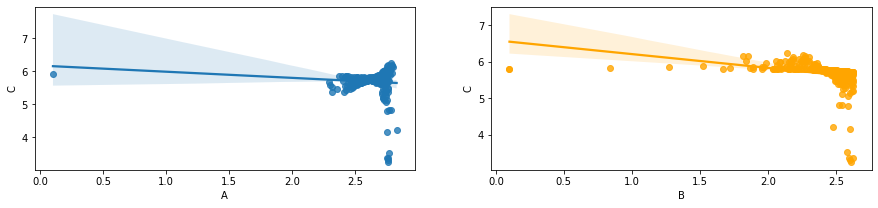

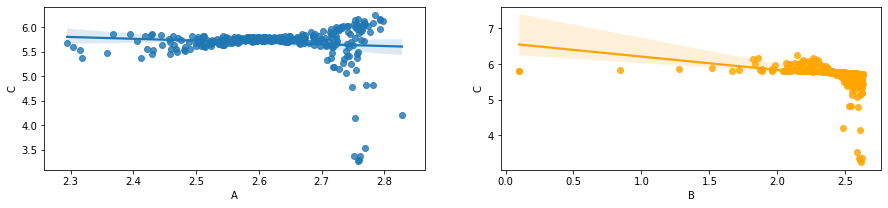

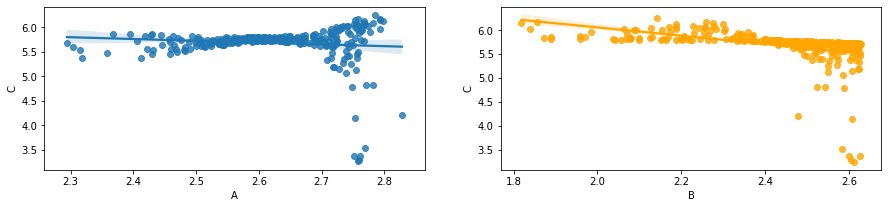

In [119]:
f,ax = plt.subplots(1,2,figsize = (15,3))
sns.regplot(x='A',y="C",data = sqrt_data, ax = ax[0])
sns.regplot(x='B',y="C",data = sqrt_data, ax = ax[1], color = 'orange')
sqrt_data = sqrt_data[sqrt_data.A > 2.0]
f,ax = plt.subplots(1,2,figsize = (15,3))
sns.regplot(x='A',y="C",data = sqrt_data, ax = ax[0])
sns.regplot(x='B',y="C",data = sqrt_data, ax = ax[1], color = 'orange')
sqrt_data = sqrt_data[sqrt_data.B > 1.75]
f,ax = plt.subplots(1,2,figsize = (15,3))
sns.regplot(x='A',y="C",data = sqrt_data, ax = ax[0])
sns.regplot(x='B',y="C",data = sqrt_data, ax = ax[1], color = 'orange')

#### I'm using package to model using GLS as I've not implemented it before from scratch and I don't want to make a delay in sending the assessment

In [120]:
X_gls = sqrt_data[['A','B']].to_numpy()
Y_gls = sqrt_data.C
gls_model = lm.GLS(Y_gls,X_gls)
gls_results = gls_model.fit()
print(gls_results.summary())

                                 GLS Regression Results                                
Dep. Variable:                      C   R-squared (uncentered):                   0.993
Model:                            GLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          2.132e+04
Date:                Mon, 24 Feb 2020   Prob (F-statistic):                   1.08e-313
Time:                        21:12:34   Log-Likelihood:                         -190.14
No. Observations:                 290   AIC:                                      384.3
Df Residuals:                     288   BIC:                                      391.6
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

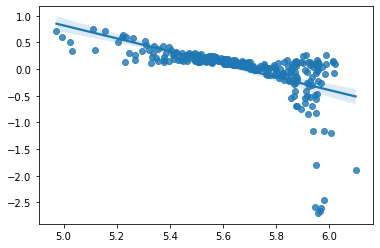

In [121]:
res = gls_results.resid
Y_hat_gls = gls_results.predict()
sns.regplot(x=Y_hat_gls,y=res)

### Now the plot looks good with reduced non-linearity and almost equal variance of residuals. R-squared is greatly improved by using Generalized least squares

## The model overfits the data but I didn't use regularization as the dataset is very small to train